In [96]:
import warnings; warnings.filterwarnings('ignore')

import itertools
import time
import copy
import numpy as np
from pprint import pprint
from itertools import cycle

from collections import defaultdict

import gymnasium as gym
from gridworld.envs import SiblingGridWorldEnv
from gymnasium.envs.registration import register
from gymnasium.wrappers import TimeLimit
import seaborn as sns
from tabulate import tabulate
import tqdm as tqdm

import torch
from torch.utils.tensorboard import SummaryWriter

import random
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "text.latex.preamble": r"\usepackage{cmbright}",
    "text.latex.preamble": r"\usepackage{bm}",
    "font.weight": "bold",
})

SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

from utils import *
from sibling_gw_agent import SiblingGWAgent

In [97]:
# plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
plt.rcParams.update(params)
np.set_printoptions(precision=3, suppress=True)

# layout = {
#     "Training": {
#         "Q_gw": ["Multiline", ["Q_gw/center", "Q_gw/corner"]],
#         "Q_bandit": ["Multiline", ["Q_bandit/zero", "Q_bandit/twenty", "Q_bandit/correct"]],
#     },
# }

# writer = SummaryWriter('runs/sibling_gw', comment="Sibling_GW")
# writer.add_custom_scalars(layout)

In [98]:
def sibling():
    env = SiblingGridWorldEnv(P_gridworld)
    env = TimeLimit(env, max_episode_steps=100)
#     env = RelativePositionenv)
    return env

register(
    id='SiblingGridWorld-v0',
    entry_point=sibling,
    max_episode_steps=100,
)

env = gym.make('SiblingGridWorld-v0')
env = env.unwrapped
 #env.render_mode = 'human'
obs, info = env.reset(options={'randomize_world': True})
print(env._true_world_idx)

10


In [99]:
n_episodes = 1
agent = SiblingGWAgent(env, gamma=1.0, 
            init_alpha=0.5, min_alpha=0.05, alpha_decay_ratio=0.5, 
            init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9, 
            n_episodes=n_episodes)
# agent = SiblingGWAgent(env, min_epsilon=0.5, epsilon_decay_ratio=0.9, n_episodes=n_episodes)
# agent.episode = 5000
# agent.epsilons[agent.episode]

In [174]:
for episode in tqdm(range(agent.episode, agent.episode + n_episodes)):
    agent.reset()
    Q_bandit = [copy.deepcopy(agent.Q_bandit)]
    # state, info = env.reset()
    state, info = env.reset(options={'randomize_world': True})
    agent.episode = episode
    done = False

    # writer.add_scalar("Q_gw/center",
    #     np.max(agent.Q_gw[agent.state_multi_to_lin(np.array([2, 2]))]), 
    #     env.num_moves
    # )
    # writer.add_scalar("Q_gw/corner",
    #     np.max(agent.Q_gw[agent.state_multi_to_lin(np.array([0, 0]))]), 
    #     env.num_moves
    # )
    # writer.add_scalar("Q_bandit/zero",
    #     np.max(agent.Q_bandit[0]), 
    #     env.num_moves
    # )
    # writer.add_scalar("Q_bandit/twenty",
    #     np.max(agent.Q_bandit[20]), 
    #     env.num_moves
    # )
    # writer.add_scalar("Q_bandit/correct",
    #     np.max(agent.Q_bandit[env._true_world_idx]), 
    #     env.num_moves
    # )
    # writer.add_image("Q_gw", 
    #     -agent.Q_gw/np.max(np.abs(agent.Q_gw)), env.num_moves, 
    #     dataformats='HW')

    while not done:
        #action = agent.select_action(state)
        action = agent.custom_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        
        # update the agent
        agent.update(state, action, reward, terminated, next_state)
        Q_bandit += [copy.deepcopy(agent.Q_bandit)]

        # update if the environment is done or truncated
        done = terminated or truncated
        state = next_state
        # time.sleep(1)

    # # if episode % 1 == 0:
    #     writer.add_scalar("Q_gw/center",
    #         np.max(agent.Q_gw[agent.state_multi_to_lin(np.array([2, 2]))]), 
    #         env.num_moves
    #     )
    #     writer.add_scalar("Q_gw/corner",
    #         np.max(agent.Q_gw[agent.state_multi_to_lin(np.array([0, 0]))]), 
    #         env.num_moves
    #     )
    #     writer.add_scalar("Q_bandit/zero",
    #         np.max(agent.Q_bandit[0]), 
    #         env.num_moves
    #     )
    #     writer.add_scalar("Q_bandit/twenty",
    #         np.max(agent.Q_bandit[20]), 
    #         env.num_moves
    #     )
    #     writer.add_scalar("Q_bandit/correct",
    #         np.max(agent.Q_bandit[env._true_world_idx]), 
    #         env.num_moves
    #     )
    #     writer.add_image("Q_gw", 
    #         -agent.Q_gw/np.max(np.abs(agent.Q_gw)), env.num_moves, 
    #         dataformats='HW')

# time.sleep(2)
# writer.flush()
# writer.close()

env.close()
print(env.num_moves)

100%|██████████| 1/1 [00:00<00:00, 166.34it/s]

8


In [175]:
Q_bandit = np.stack(Q_bandit, axis=1)

In [176]:
max_value = np.max(Q_bandit[:,-1])
max_indices = np.where(Q_bandit[:,-1] == max_value)[0]
max_value, max_indices, env._true_world_idx, agent.graylist

(1.0, array([ 7, 10, 13, 16]), 13, set())

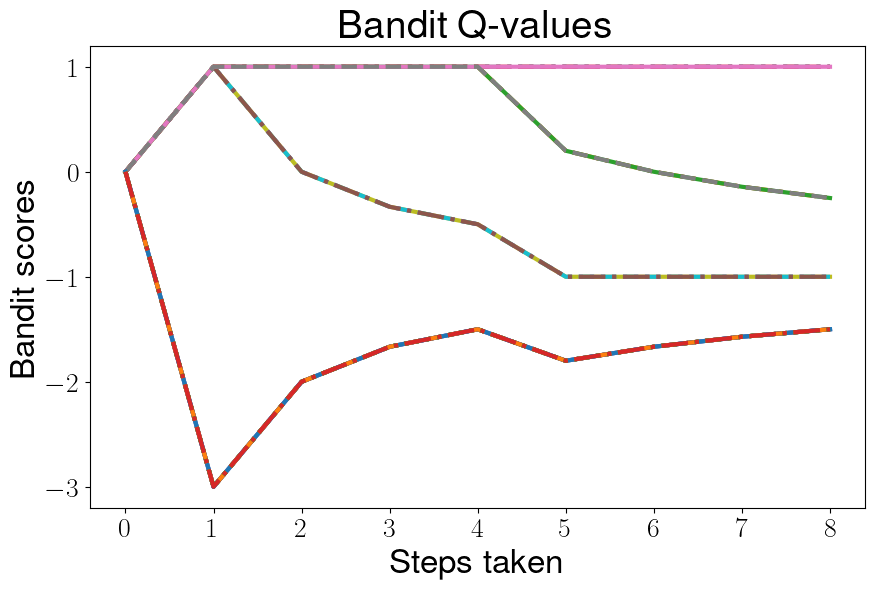

In [177]:
lines = ["-","--",":","-."]
linecycler = cycle(lines)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for i in range(24):
    ln = next(linecycler)
    ax.plot(Q_bandit[i,:], ln, linewidth=3)
ax.set_title("Bandit Q-values")
ax.set_xlabel("Steps taken")
ax.set_ylabel("Bandit scores")
fig.savefig("../TeX/robot_on_chessboard/english_v2/figures/bandit_scores.eps", format="eps", dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [201]:
rng = np.random.default_rng()
obs, info = env.reset(options={'randomize_world': True})
# env.render_mode = 'human'
agent.reset()

n_episodes = 200_000
avg_steps = 100
alpha = 1e-5
running_avg = np.zeros(n_episodes+1, dtype=np.float32)
running_avg[0] = 7.0 
state_count = np.zeros((5, 5), dtype=int)
# all_steps = np.zeros(n_episodes+1, dtype=int)
# all_bad_moves = np.zeros(n_episodes+1, dtype=int)
avg_bad_moves = 2
for e in tqdm(range(1, n_episodes+1)):
    obs, info = env.reset(options={'randomize_world': True})
    agent.reset()
    done = False
    while not done:
        state_count[*obs] += 1
        # time.sleep(0.5)
        # action = agent.greedy_action(obs)
        action = agent.custom_action(obs)
        next_obs, rew, term, trunc, info = env.step(action)
        
        agent.update(obs, action, rew, term, next_obs)

        done = term or trunc
        obs = next_obs

        if done:
            state_count[*obs] += 1
            # time.sleep(0.5)
            # print(f"Finished in {env.num_moves} steps.")
            # all_steps[e] = env.num_moves
            avg_steps += 1/e * (env.num_moves - avg_steps)
            # all_bad_moves[e] = env.bad_moves
            avg_bad_moves += 1/e * (env.bad_moves - avg_bad_moves)
            running_avg[e] = (1-alpha) * running_avg[e-1] + alpha * env.num_moves
            break

print(f"Average steps: {avg_steps}; Average bad moves:{avg_bad_moves}",)
# time.sleep(2)
env.close()

100%|██████████| 200000/200000 [13:08<00:00, 253.59it/s]

Average steps: 6.66608999999993; Average bad moves:1.33304500000003


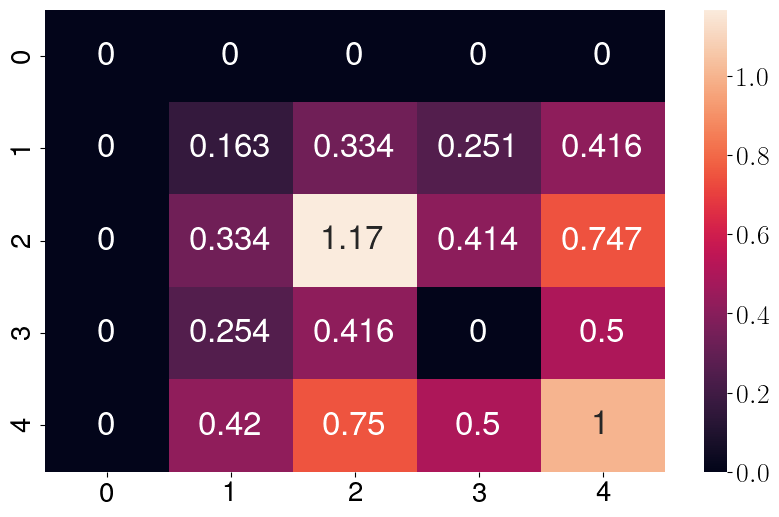

In [182]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
sns.heatmap(state_count/9999, annot=True, fmt='.3g', ax=ax)
fig.savefig("../TeX/robot_on_chessboard/english_v2/figures/visit_count_ratio.eps", format="eps", dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [184]:
np.sum(state_count) - state_count[4, 4]

66650

In [15]:
all_bad_moves.min(), all_bad_moves.max()

(0, 2)

In [16]:
print(np.bincount(all_bad_moves) / np.sum(np.bincount(all_bad_moves)))
np.bincount(all_steps) / np.sum(np.bincount(all_steps))

[0.159 0.333 0.508]


array([0.   , 0.   , 0.   , 0.   , 0.159, 0.   , 0.333, 0.   , 0.508])

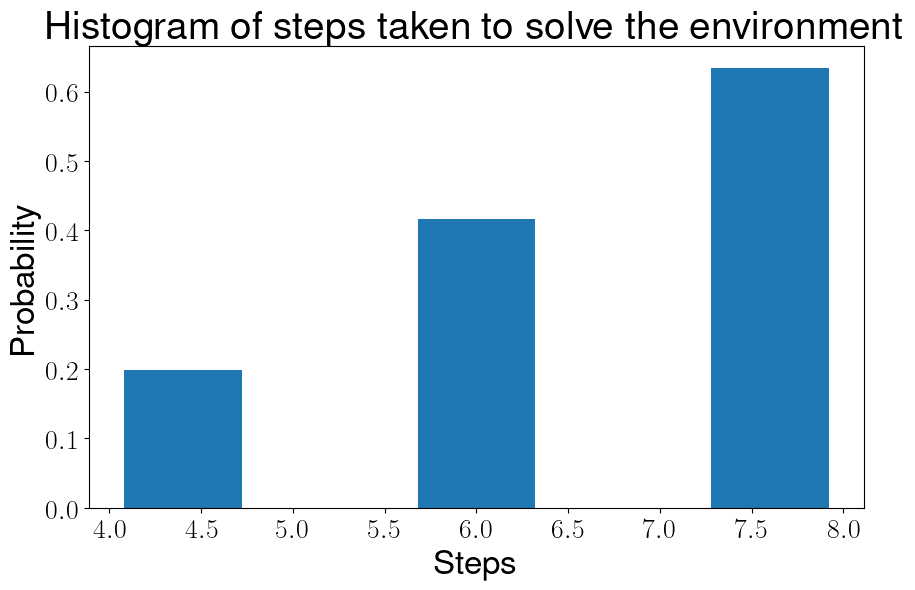

In [17]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.hist(all_steps, bins=5, rwidth=0.8, density=True)
ax.set_title("Histogram of steps taken to solve the environment")
ax.set_xlabel("Steps")
ax.set_ylabel("Probability")
fig.savefig("../TeX/robot_on_chessboard/english_v2/figures/steps_histogram.eps", format="eps", dpi=1000, bbox_inches='tight', pad_inches=0.1)

(array([1590.,    0., 3333.,    0., 5076.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. ]),
 <BarContainer object of 5 artists>)

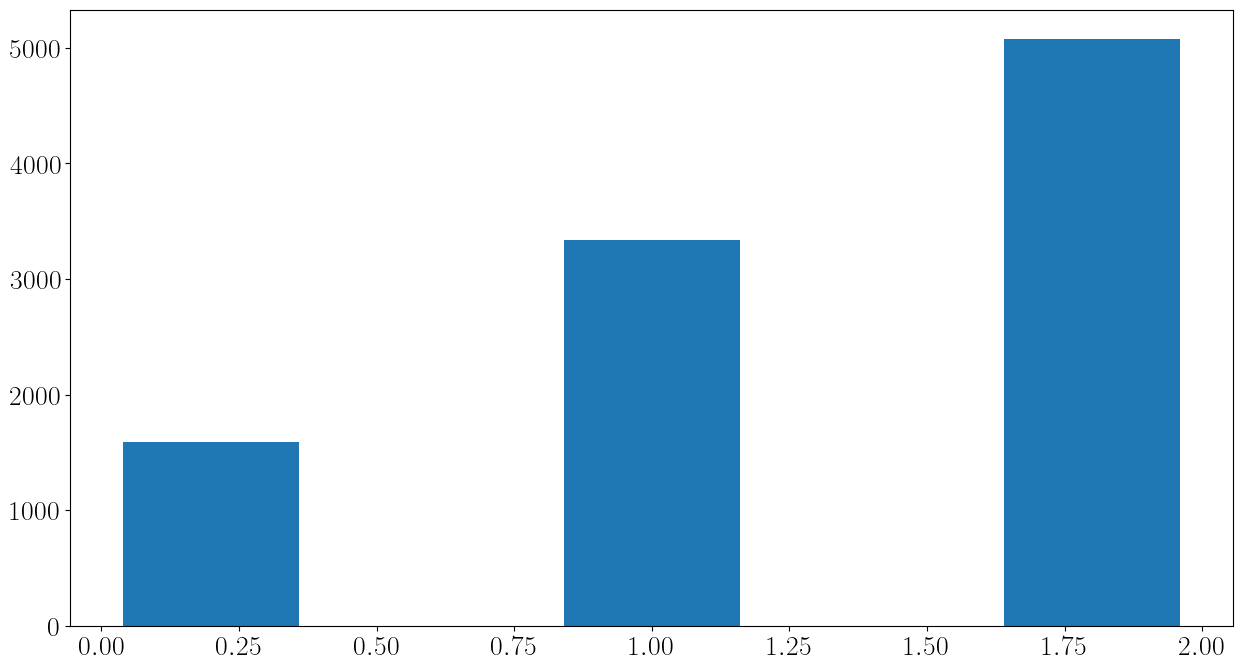

In [18]:
plt.hist(all_bad_moves, bins=5, rwidth=0.8)

In [19]:
agent.env._true_world_idx, agent.env._world_belief ,agent.N_bandit,agent.Q_bandit

(18,
 array([6]),
 array([4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4], dtype=int32),
 array([0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
        1., 1., 1., 0., 0., 0., 0.], dtype=float32))

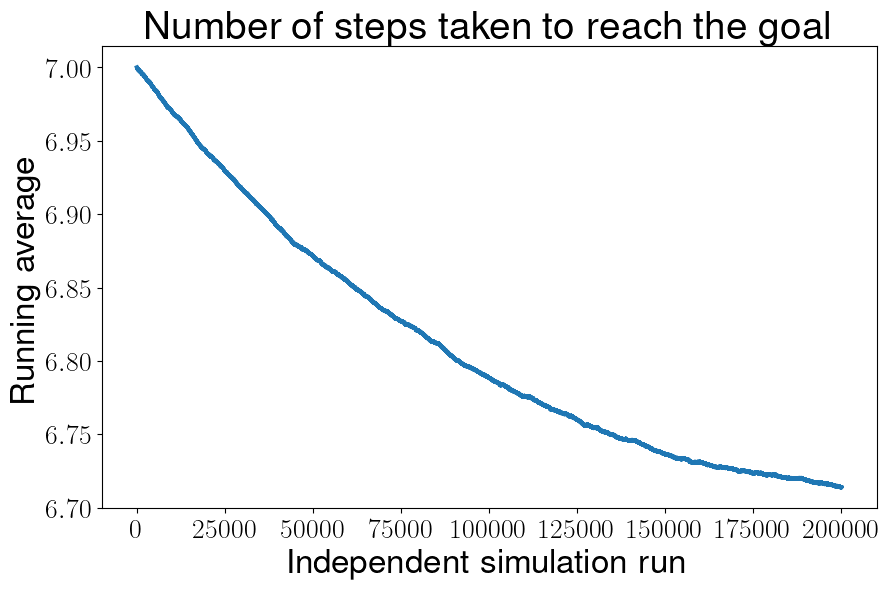

In [202]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(running_avg, linewidth=3)
ax.set_title("Number of steps taken to reach the goal")
ax.set_xlabel("Independent simulation run")
ax.set_ylabel("Running average")
fig.savefig("../TeX/robot_on_chessboard/english_v2/figures/running_avg.eps", format="eps", dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [21]:
rng = np.random.default_rng()
env.render_mode = None
obs, _ = env.reset()
agent.reset()
# obs, info = env.reset(options={'randomize_world': True})
# env._agent_location = np.array([2, 2])
# obs = env._agent_location

avg_steps = 100
alpha = 0.1
running_avg = [10]
max_ep_len = 20
for e in tqdm(range(1, 1_000)):
    for i in range(1, max_ep_len):
        # action = agent.greedy_action(obs)
        action = agent.custom_action(obs)
        obs, rew, done, trunc, info = env.step(action)
        # print(obs, rew, info)
        # time.sleep(0.05)
        if done or i == max_ep_len - 1:
            # print(f"Finished in {i} steps.")
            avg_steps += 1/e * (i - avg_steps)
            running_avg += [(1-alpha) * running_avg[-1] + alpha * avg_steps]
            break
    obs, _ = env.reset()
    env._agent_location = np.array([2, 2])
    obs = env._agent_location
    # if e % 100 == 0:
    #     print(f"Episode {e} finished, current average estimate is {avg_steps}.")

print(f"Cumulative average estimate: {avg_steps}")

100%|██████████| 999/999 [00:05<00:00, 196.05it/s]

Cumulative average estimate: 19.0


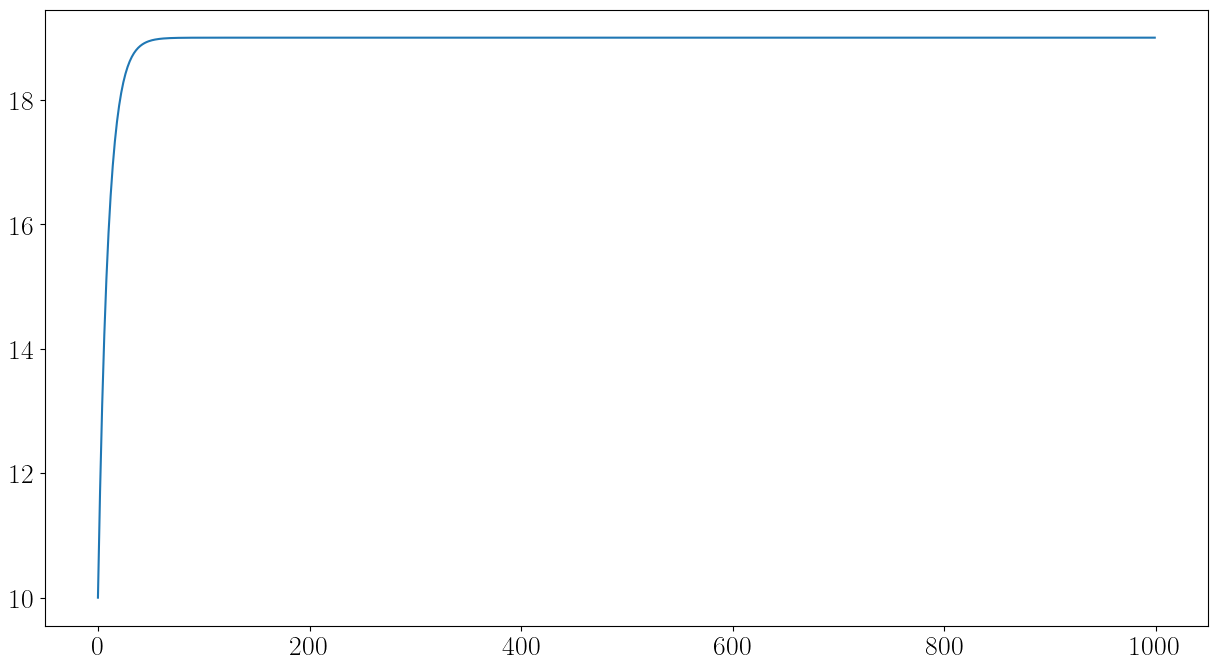

In [22]:
plt.plot(running_avg)